# Configuration

In [10]:

# --- Imports
import os
from pathlib import Path


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Optional irsdk (for .ibt)
try:
    import irsdk
    IRSDK_AVAILABLE = True
except Exception:
    IRSDK_AVAILABLE = False

print(f"irsdk available   : {IRSDK_AVAILABLE}")

# --- Paths & Parameters
USE_IBT = True  # set True to read a .ibt with irsdk if available


# Laps to visualize in the "quick overlay" plots (only visualization; robust pipeline auto-selects reference)
laps_to_plot = [2, 3, 4]

# Core pipeline settings
N_SECTORS = 4               # number of sectors to split the track
BASE_GRID_LEN = 1000
TOPK_PERCENT = 0.30          # robust sector reference: median of fastest top K%
PACE_THRESHOLD_MS = 3000.0   # drop laps whose sum of positive sector losses > 2s
CLIP_MS = 1500.0             # clip training target (ms)
SEQ_LEN = 128                # per-sector resampling for stability
SEED = 42

# Output directory
OUT_DIR = Path("simulator_outputs")
OUT_DIR.mkdir(parents=True, exist_ok=True)


irsdk available   : True


# Dataset Loading

In [17]:
import irsdk
import pandas as pd
import numpy as np
from pathlib import Path

# --- Configuration ---
IBT_FILES = [
    Path("dataset_30_laps/mx5 mx52016_charlotte 2025 roval2025 2025-11-17 14-27-06.ibt"), 
    Path("dataset_30_laps/mx5 mx52016_charlotte 2025 roval2025 2025-11-17 14-59-46.ibt")
]
USE_IBT = True
IRSDK_AVAILABLE = True 

def load_from_ibt(ibt_path: Path) -> pd.DataFrame:
    """
    Loads binary IBT file using irsdk.
    """
    if not IRSDK_AVAILABLE:
        raise RuntimeError("irsdk is not available in this environment.")
    if not ibt_path.exists():
        raise FileNotFoundError(f".ibt file not found: {ibt_path}")
    
    ibt = irsdk.IBT()
    try:
        ibt.open(str(ibt_path))
        channels = ['SessionTime','Lap','Speed','RPM','Throttle','Brake',
                    'LapDistPct','Lat','Lon','SteeringWheelAngle','Gear',
                    'LatAccel','LongAccel']
        data = {ch: ibt.get_all(ch) for ch in channels}
    except Exception as e:
        print(f"[ERROR] Failed to open {ibt_path}: {e}")
        return pd.DataFrame() 
    finally:
        ibt.close()
    return pd.DataFrame(data)

def basic_clean_and_units(df: pd.DataFrame) -> pd.DataFrame:
    """
    Performs basic data cleaning (Inf/NaN removal) and unit conversion.
    """
    df = df.copy()
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.dropna(inplace=True)
    
    if "Speed_KPH" not in df.columns and "Speed" in df.columns:
        df["Speed_KPH"] = df["Speed"] * 3.6
    if "Throttle_Pct" not in df.columns and "Throttle" in df.columns:
        df["Throttle_Pct"] = df["Throttle"] * 100.0
    if "Brake_Pct" not in df.columns and "Brake" in df.columns:
        df["Brake_Pct"] = df["Brake"] * 100.0
    return df

def process_multi_session_data(file_list):
    """
    Loads multiple IBT files, cleans them individually, and stitches them 
    into a single continuous timeline for stochastic analysis.
    """
    processed_dfs = []
    
    # Global Offset Controller
    global_lap_counter = 0 
    
    print(f"[PIPELINE] Starting ingestion of {len(file_list)} files...")

    for i, file_path in enumerate(file_list):
        print(f"   -> Processing File {i+1}: {file_path.name}")
        
        # 1. Load & Basic Units
        raw_df = load_from_ibt(file_path)
        if raw_df.empty: continue
        current_df = basic_clean_and_units(raw_df)
        
        # --- CRITICAL STEP: INVALID LAP REMOVAL ---
        # Identify valid laps for THIS specific file.
        # Usually, we remove the first (Outlap/Warmup) and the last (Inlap/Incomplete).
        min_lap = current_df['Lap'].min()
        max_lap = current_df['Lap'].max()
        
        # Rule: Keep only laps strictly between min and max.
        # This ensures we remove the cold Outlap and the incomplete Inlap.
        current_df = current_df[(current_df['Lap'] > min_lap) & (current_df['Lap'] < max_lap)].copy()
        
        if current_df.empty:
            print(f"      [WARNING] File {i+1} resulted in empty data after filtering outlaps.")
            continue
            
        # 2. Re-indexing (Stitching)
        # Now that we have only clean laps, we re-number them to follow the global sequence.
        # Example: File 1 has 15 laps. File 2 has 15 laps.
        # Final Result: Laps 1 to 30 continuous.
        
        # Normalize local lap count to start at 1 (removes local offset)
        current_df['Lap'] = current_df['Lap'] - current_df['Lap'].min() + 1
        
        # Add the global counter to continue the sequence
        current_df['Lap'] += global_lap_counter
        
        # Update the global counter for the next file iteration
        laps_in_this_file = current_df['Lap'].nunique()
        global_lap_last_val = current_df['Lap'].max()
        
        print(f"      [INFO] Extracted {laps_in_this_file} valid laps. Mapped to Global Laps: {current_df['Lap'].min()} -> {current_df['Lap'].max()}")
        
        global_lap_counter = global_lap_last_val
            
        processed_dfs.append(current_df)

    # 4. Concatenate
    if processed_dfs:
        full_df = pd.concat(processed_dfs, ignore_index=True)
        
        # Recalculate SessionTime to be continuous (Optional, but recommended for plotting X(t))
        # Create a synthetic continuous time based on index
        # (Assuming constant sampling rate, e.g., 60Hz)
        full_df['SessionTime'] = np.arange(len(full_df)) * (1/60.0) 
        
        print(f"[PIPELINE] Complete. Total Data Points: {len(full_df)}")
        print(f"[PIPELINE] Total Valid Laps: {full_df['Lap'].nunique()}")
        return full_df
    else:
        raise RuntimeError("No data could be loaded.")

# --- Execute Pipeline ---
if USE_IBT:
    df = process_multi_session_data(IBT_FILES)
    

[PIPELINE] Starting ingestion of 2 files...
   -> Processing File 1: mx5 mx52016_charlotte 2025 roval2025 2025-11-17 14-27-06.ibt
      [INFO] Extracted 13 valid laps. Mapped to Global Laps: 1 -> 13
   -> Processing File 2: mx5 mx52016_charlotte 2025 roval2025 2025-11-17 14-59-46.ibt
      [INFO] Extracted 18 valid laps. Mapped to Global Laps: 14 -> 31
[PIPELINE] Complete. Total Data Points: 185589
[PIPELINE] Total Valid Laps: 31


## Quick sanity check

In [ ]:

print(df.head())
print(df.tail())

   SessionTime  Lap      Speed          RPM  Throttle  Brake  LapDistPct  \
0     0.000000    1  24.189777  6353.956543       1.0    0.0    0.000053   
1     0.016667    1  24.250711  6355.349121       1.0    0.0    0.000165   
2     0.033333    1  24.312675  6355.340820       1.0    0.0    0.000277   
3     0.050000    1  24.373638  6352.822266       1.0    0.0    0.000389   
4     0.066667    1  24.433487  6350.770020       1.0    0.0    0.000502   

         Lat        Lon  SteeringWheelAngle  Gear  LatAccel  LongAccel  \
0  35.352290 -80.685640            0.020582     1 -0.767404   3.767957   
1  35.352286 -80.685641            0.020124     1 -0.446361   3.842361   
2  35.352283 -80.685642            0.019439     1 -0.492839   3.838492   
3  35.352279 -80.685643            0.019439     1 -0.550015   3.775527   
4  35.352276 -80.685645            0.019439     1 -0.618664   3.716111   

   Speed_KPH  Throttle_Pct  Brake_Pct  
0  87.083199         100.0        0.0  
1  87.302561      

In [21]:
#Show laptime for each lap

lap_times = df.groupby('Lap')['SessionTime'].agg(['min', 'max'])
print(lap_times)



             min          max
Lap                          
1       0.000000   113.316667
2     113.333333   217.033333
3     217.050000   316.966667
4     316.983333   417.000000
5     417.016667   516.350000
6     516.366667   615.350000
7     615.366667   714.516667
8     714.533333   816.633333
9     816.650000   915.566667
10    915.583333  1016.500000
11   1016.516667  1115.616667
12   1115.633333  1214.416667
13   1214.433333  1313.883333
14   1313.900000  1413.150000
15   1413.166667  1511.250000
16   1511.266667  1609.166667
17   1609.183333  1707.800000
18   1707.816667  1807.166667
19   1807.183333  1906.200000
20   1906.216667  2005.033333
21   2005.050000  2103.250000
22   2103.266667  2201.000000
23   2201.016667  2298.816667
24   2298.833333  2396.633333
25   2396.650000  2494.716667
26   2494.733333  2597.750000
27   2597.766667  2695.583333
28   2695.600000  2792.966667
29   2792.983333  2892.150000
30   2892.166667  2990.400000
31   2990.416667  3093.133333


# 2) Statistical Properties Analysis

[INFO] Analyzing Laps: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30]


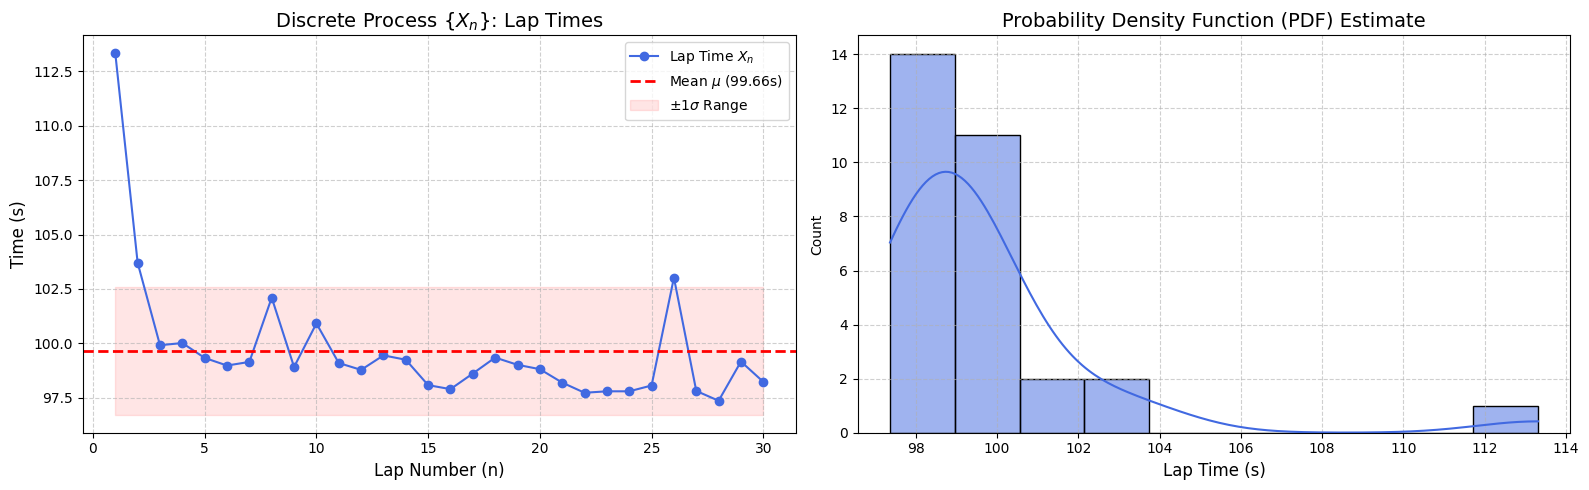

[RESULTS] Discrete Process {X_n} Statistics:
   - Mean (E[X]): 99.6639 s
   - Std Dev (sigma): 2.9361 s


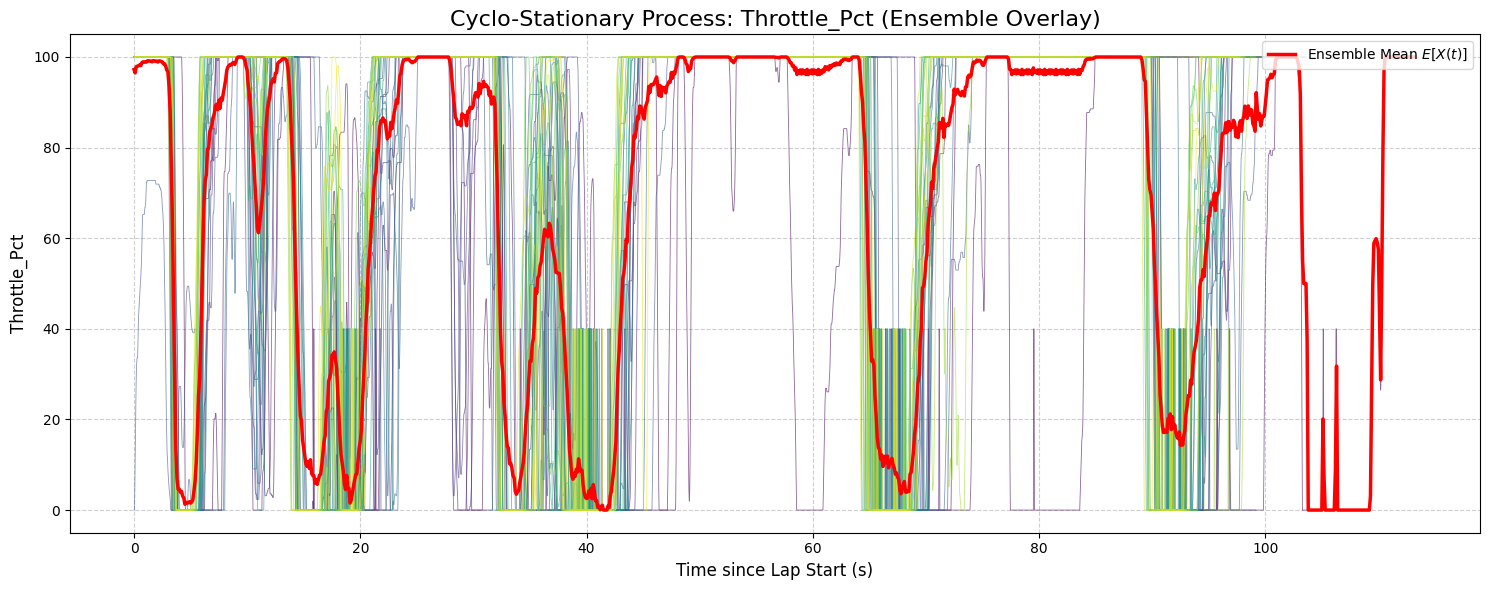

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# --- Configuration ---
COL_TIME = 'SessionTime'      
COL_LAP = 'Lap'              
COL_VAR = 'Throttle_Pct'      

# Ensure we are working with the clean dataframe
max_lap = df[COL_LAP].max()
df_analysis = df[(df[COL_LAP] > 0) & (df[COL_LAP] < max_lap)].copy() 

print(f"[INFO] Analyzing Laps: {df_analysis[COL_LAP].unique()}")

# 1. Prepare Data: Calculate 'LocalLapTime'
df_analysis['LapStartTime'] = df_analysis.groupby(COL_LAP)[COL_TIME].transform('min')
df_analysis['LocalLapTime'] = df_analysis[COL_TIME] - df_analysis['LapStartTime']

def analyze_discrete_stationarity(df, lap_col, time_col):
    """
    Analyzes the Wide-Sense Stationarity (WSS) of the Lap Times {X_n}.
    Checks for constant Mean and Variance over time.
    """
    lap_times = df.groupby(lap_col)['LocalLapTime'].max()
    laps = lap_times.index
    times = lap_times.values

    mu = np.mean(times)
    sigma = np.std(times)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))
    
    # Subplot 1: The Process X_n
    ax1.plot(laps, times, marker='o', linestyle='-', color='royalblue', label=r'Lap Time $X_n$')
    # FIX: Added 'r' before strings with latex symbols
    ax1.axhline(mu, color='red', linestyle='--', linewidth=2, label=rf'Mean $\mu$ ({mu:.2f}s)')
    ax1.fill_between(laps, mu - sigma, mu + sigma, color='red', alpha=0.1, label=r'$\pm 1 \sigma$ Range')
    
    ax1.set_title(r'Discrete Process $\{X_n\}$: Lap Times', fontsize=14)
    ax1.set_xlabel('Lap Number (n)', fontsize=12)
    ax1.set_ylabel('Time (s)', fontsize=12)
    ax1.legend()
    ax1.grid(True, linestyle='--', alpha=0.6)
    
    # Subplot 2: PDF
    sns.histplot(times, kde=True, ax=ax2, bins=10, color='royalblue', edgecolor='black')
    ax2.set_title('Probability Density Function (PDF) Estimate', fontsize=14)
    ax2.set_xlabel('Lap Time (s)', fontsize=12)
    ax2.grid(True, linestyle='--', alpha=0.6)
    
    plt.tight_layout()
    plt.show()
    
    print(f"[RESULTS] Discrete Process {{X_n}} Statistics:")
    print(f"   - Mean (E[X]): {mu:.4f} s")
    print(f"   - Std Dev (sigma): {sigma:.4f} s")

def analyze_cyclostationarity(df, target_col):
    """
    Visualizes the Cyclo-Stationarity of the continuous signal X(t).
    """
    plt.figure(figsize=(15, 6))
    
    sns.lineplot(data=df, x='LocalLapTime', y=target_col, 
                 hue=COL_LAP, palette='viridis', 
                 linewidth=0.6, alpha=0.6, legend=None)
    
    df['TimeBin'] = df['LocalLapTime'].round(1) 
    ensemble_mean = df.groupby('TimeBin')[target_col].mean()
    
    plt.plot(ensemble_mean.index, ensemble_mean.values, 
             color='red', linewidth=2.5, label=r'Ensemble Mean $E[X(t)]$')
    
    plt.title(f'Cyclo-Stationary Process: {target_col} (Ensemble Overlay)', fontsize=16)
    plt.xlabel('Time since Lap Start (s)', fontsize=12)
    plt.ylabel(target_col, fontsize=12)
    plt.legend(loc='upper right')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

# --- Execution ---
analyze_discrete_stationarity(df_analysis, COL_LAP, COL_TIME)
analyze_cyclostationarity(df_analysis, COL_VAR)

O Gráfico acima representa toda as realizações das 30 voltas da varíavel "pedal do acelerador (%)".

Alguns insights podem ser gerados a partir dele:

* Para cada linha colorida, é uma volta individual dada na pista de Charlotte. Elas representam a aleatoriedade. Nota-se que elas nunca são idênticas, de modo que em alguns lugares elas se sobrepõem perfeitamente (nas retas), e em outros elas se espalham (nas curvas).

* A Linha vermelha ($E[X(t)$): Esta é a Média do conjunto.Matematicamente, para cada instante de tempo $t$ (por exemplo, aos 10 segundos da volta), o código pegou o valor do acelerador de todas as 30 voltas e calculou a média. Ela representa o "comportamento esperado" do sistema. 

* Não-Estacionário: através da análise da média em vermelho,depende do tempo $t$, o processo não é estacionário.  Analisando outro por outro viés, se o processo fosse Estacionário (WSS), a linha vermelha seria uma reta horizontal (constante).

* 

## 